Random Forest Classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('/content/predicted_dataset.xlsx')

# Impute missing values (replace NaN with mean)
imputer = SimpleImputer(strategy='mean')
X = data[['Humidity', 'Day Temp', 'Night Temp', 'Crop Growth']]
X = imputer.fit_transform(X)
y = data['Risk']

# Ensure labels start from 0
y = y - 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for Random Forest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a RandomForestClassifier with adjusted hyperparameters
model_rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])

# Input new data for inference
new_data = pd.DataFrame({'Humidity': [2], 'Day Temp': [1], 'Night Temp': [3], 'Crop Growth': [3]})
new_data = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data)
new_data_scaled = new_data_scaled.astype('float32')

# Perform inference with the Random Forest model
predicted_class_rf = model_rf.predict(new_data)
predicted_class_rf = int(predicted_class_rf[0]) + 1

print("Predicted Class (Random Forest) for New Data:", predicted_class_rf)


Predicted Class (Random Forest) for New Data: 2


Random Forest to Tflite Conversion

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Load the dataset
data = pd.read_excel('/content/predicted_dataset.xlsx')

# Impute missing values (replace NaN with mean)
imputer = SimpleImputer(strategy='mean')
X = data[['Humidity', 'Day Temp', 'Night Temp', 'Crop Growth']]
X = imputer.fit_transform(X)
y = data['Risk']

# Ensure labels start from 0
y = y - 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a RandomForestClassifier with adjusted hyperparameters
model_rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])

# Build a Neural Network model with adjusted architecture
tf_model = keras.Sequential([
    keras.layers.Input(shape=(4,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf_model.fit(X_train_scaled, y_train, epochs=500, batch_size=32,verbose=0)

# Convert the TensorFlow model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Input new data for inference
new_data = pd.DataFrame({'Humidity': [2], 'Day Temp': [1], 'Night Temp': [3], 'Crop Growth': [3]})
new_data = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data)
new_data_scaled = new_data_scaled.astype('float32')

# Perform inference with the Random Forest model
predicted_class_rf = model_rf.predict(new_data)
predicted_class_rf = int(predicted_class_rf[0]) + 1

# Perform inference with the TensorFlow Lite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], new_data_scaled)
interpreter.invoke()
predicted_class_nn = interpreter.get_tensor(output_details[0]['index'])
predicted_class_nn = int(tf.argmax(predicted_class_nn, axis=1).numpy()[0]) + 1

print("Predicted Class (Random Forest) for New Data:", predicted_class_rf)
print("Predicted Class (Neural Network) for New Data:", predicted_class_nn)


Predicted Class (Random Forest) for New Data: 2
Predicted Class (Neural Network) for New Data: 2


Metrics calculations for both Models

Random Forest Model Metrics:
Accuracy: 0.9615384615384616
Classification Report:
                precision    recall  f1-score   support

    High Risk       1.00      1.00      1.00        19
Moderate Risk       1.00      0.92      0.96        13
     Low Risk       0.89      0.89      0.89         9
      No Risk       0.92      1.00      0.96        11

     accuracy                           0.96        52
    macro avg       0.95      0.95      0.95        52
 weighted avg       0.96      0.96      0.96        52

Confusion Matrix:
 [[19  0  0  0]
 [ 0 12  1  0]
 [ 0  0  8  1]
 [ 0  0  0 11]]
Precision: 0.9631410256410255
Recall: 0.9615384615384616


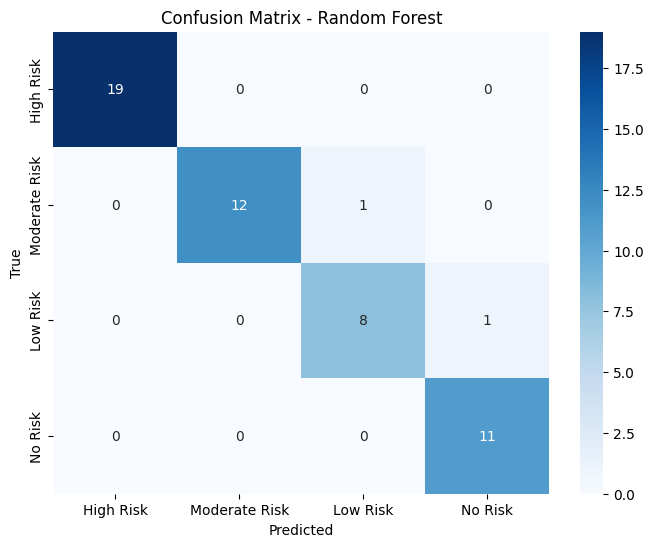

2/2 [==============================] - 0s 7ms/step

Neural Network Model Metrics:
Accuracy: 0.9807692307692307
Classification Report:
                precision    recall  f1-score   support

    High Risk       1.00      1.00      1.00        19
Moderate Risk       1.00      0.92      0.96        13
     Low Risk       0.90      1.00      0.95         9
      No Risk       1.00      1.00      1.00        11

     accuracy                           0.98        52
    macro avg       0.97      0.98      0.98        52
 weighted avg       0.98      0.98      0.98        52

Confusion Matrix:
 [[19  0  0  0]
 [ 0 12  1  0]
 [ 0  0  9  0]
 [ 0  0  0 11]]
Precision: 0.9826923076923078
Recall: 0.9807692307692307


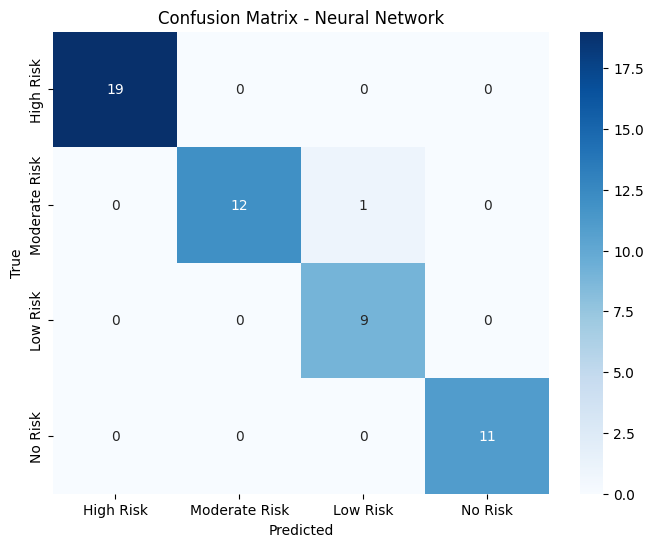

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

# Load the dataset
data = pd.read_excel('/content/predicted_dataset.xlsx')

# Impute missing values (replace NaN with mean)
imputer = SimpleImputer(strategy='mean')
X = data[['Humidity', 'Day Temp', 'Night Temp', 'Crop Growth']]
X = imputer.fit_transform(X)
y = data['Risk']

# Ensure labels start from 0
y = y - 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a RandomForestClassifier with adjusted hyperparameters
model_rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print metrics for Random Forest
print("Random Forest Model Metrics:")
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", classification_rep_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

precision_rf = precision_score(y_test, y_pred_rf, average='weighted')  # Use 'micro', 'macro', or 'weighted'
print("Precision:", precision_rf)

recall_rf = recall_score(y_test, y_pred_rf, average='weighted')  # Use 'micro', 'macro', or 'weighted' for multiclass
print("Recall:", recall_rf)

# Plot colored confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'], yticklabels=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Build a Neural Network model with adjusted architecture
tf_model = keras.Sequential([
    keras.layers.Input(shape=(4,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf_model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, verbose=0)

# Evaluate the Neural Network model
y_pred_nn_probabilities = tf_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn_probabilities.argmax(axis=-1)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
classification_rep_nn = classification_report(y_test, y_pred_nn, target_names=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)

# Print metrics for Neural Network
print("\nNeural Network Model Metrics:")
print("Accuracy:", accuracy_nn)
print("Classification Report:\n", classification_rep_nn)
print("Confusion Matrix:\n", conf_matrix_nn)

# Calculate Precision for Neural Network
precision_nn = precision_score(y_test, y_pred_nn, average='weighted')  # Use 'micro', 'macro', or 'weighted'
print("Precision:", precision_nn)

# Calculate Recall for Neural Network
recall_nn = recall_score(y_test, y_pred_nn, average='weighted')  # Use 'micro', 'macro', or 'weighted'
print("Recall:", recall_nn)

# Plot colored confusion matrix for Neural Network
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'], yticklabels=['High Risk', 'Moderate Risk', 'Low Risk', 'No Risk'])
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()